# Real-world representation using tensors
- Jackson Cown
- 6/10/22


#### In This Chapter:
- Represent real-world data as PyTorch Tensors
- Working with a range of data file type
- Loading data from a file
- Converting data to tensors
- Shaping tensors so they can be used as inputs to neural network models

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Real-world data as tensors
- Tensors are the building blocks of data in PyTorch
- NNs take tensors as input and produce tensors as outputs
- In fact, all operations within a neural network during optimization are operations between tensors
- How do we take a piece of data, a video, or a line of text, and represent it with a tensor in a way that is appropriate for training a deep learning model?
    - Each section in this chapter will describe a data type, and will come with their own datasets

### Working with images
- Since the reemergence of deep learning in 2012, Convolutions Neural Networks (CNNs) have been at the forefront of the research community.
    - The primary use of these CNNs is in processing 2D image data but it is not limited to only this
- An image is represented as a collection of scalars arranged in a regular grid with a height and a width (in pixels)
- We might have a single scalar grid point (grayscale img), or multiple scalars per grid point (color img)
    - Or we can have an axis representing depth or other types of features
- Scalar represented values are often encoded with 8-bit integers, as in consumer cameras.
    - Medical, scientific, and industrial applications use higher numerical precision, such as 12-bit or 16-bit
    - This allows for a wider range of sentivity in cases where the pixel encodes information about a physical property (like temperature)


#### Adding color channels
- There are several ways to encode color into numbers, the most common being RGB. (3 channels representing Red, Blue, and Green respectively.
    - We can think of a color channel as a grayscale intensity map of only the color in question


#### Loading an image file
- Loading PNG images using ```imageio``` module

In [2]:
# Loading png images
import imageio.v2 as imageio
from matplotlib import pyplot as plt

In [3]:
img_arr = imageio.imread('./data/p1ch4/image-dog/bobby.jpg')

(720, 1280, 3)
uint8


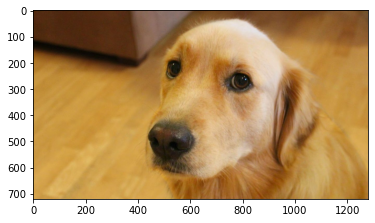

In [4]:
print(img_arr.shape)
print(img_arr.dtype)
plt.imshow(img_arr)

At this point, ```img_arr``` is a NumPy array-like object with 3 dimensions:
- Two Spatial Dimensions
    - Width and Height
- One dimension corresponding to color intensity (RGB)
- Default notation for image dimensions in PyTorch is **CxHxW**: Channels, Height, Width


#### Changing the layout
- We can use the tensors ```permute``` method with the old dimensions for eacvh new dimension to get an appropriate layout.
- Given a tensor **HxWxC**, we get a proper layout by swapping each index by up one

In [5]:
img = torch.from_numpy(img_arr)
print(f'Original image shape: {img.shape}')
out = img.permute(2, 0, 1) # Does not make a copy, only changes tensor view of storage
print(f'Permuted image shape: {out.shape}')
print(out.dtype)

Original image shape: torch.Size([720, 1280, 3])
Permuted image shape: torch.Size([3, 720, 1280])
torch.uint8


To create a dataset of multiple images to use during training, we store the images in a batch along the first dimension to obtain a **NxCxHxW** tensor

In [6]:
#img batching
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)
# Each batch consists of 3 RGB images 256x256

We can also load all PNG images from an input directory and store them in the tensor:

In [7]:
import os

data_dir = './data/p1ch4/image-cats'
filenames = [name for name in os.listdir(data_dir)
            if os.path.splitext(name)[-1] == '.png']
print(filenames)

['cat1.png', 'cat2.png', 'cat3.png']


In [8]:
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # Here we only keep the first 3 channels (sometimes there is an alpha channel)
    batch[i] = img_t

#### Normalizing the data
- Images are natively integer values ranging from 0-255
    - We need to adjust this because neural networks learn better when the output is bounded between 0 to 1 or from -1 to 1
- A common thing to do is to cast a tensor to floating-point dtype and normalize the pixel values
- An easy way to do this is to just convert to float and divide by 255 element wise on each image

In [9]:
batch = batch.float()
batch /= 255.0
print(batch[0, 0])

tensor([[0.6118, 0.5961, 0.4863,  ..., 0.5882, 0.5843, 0.6196],
        [0.6824, 0.5255, 0.6471,  ..., 0.4706, 0.5333, 0.5412],
        [0.4980, 0.6118, 0.4196,  ..., 0.5137, 0.5608, 0.6431],
        ...,
        [0.4549, 0.5098, 0.5059,  ..., 0.4980, 0.4627, 0.4392],
        [0.5059, 0.5098, 0.4824,  ..., 0.4510, 0.4745, 0.4471],
        [0.5059, 0.4824, 0.4627,  ..., 0.4431, 0.4745, 0.4706]])


- Another way to do it is to compute the mean and standard deviation of the input data and scale it so the output has zero mean and unit standard deviation across each channel:

In [10]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std
print(batch[0, 0])

tensor([[ 0.1439,  0.0730, -0.4234,  ...,  0.0375,  0.0198,  0.1794],
        [ 0.4631, -0.2461,  0.3035,  ..., -0.4944, -0.2107, -0.1752],
        [-0.3703,  0.1439, -0.7249,  ..., -0.2993, -0.0866,  0.2858],
        ...,
        [-0.5653, -0.3171, -0.3348,  ..., -0.3703, -0.5298, -0.6362],
        [-0.3348, -0.3171, -0.4412,  ..., -0.5830, -0.4766, -0.6007],
        [-0.3348, -0.4412, -0.5298,  ..., -0.6185, -0.4766, -0.4944]])


Note:
- Here we normalize only a single batch of images because we do not know yet how to operate on an entire dataset.
    - With image data, it can be better to compute the mean and standard deviation over the whole dataset
- We can perform several other operations on the inputs, such as geometric transforms like rotations, scaling, and cropping
    - These may help with training or may be required to make an arbitrary input conform to the input requirements of a network, like image size.

### 3D Images: Volumetric Data
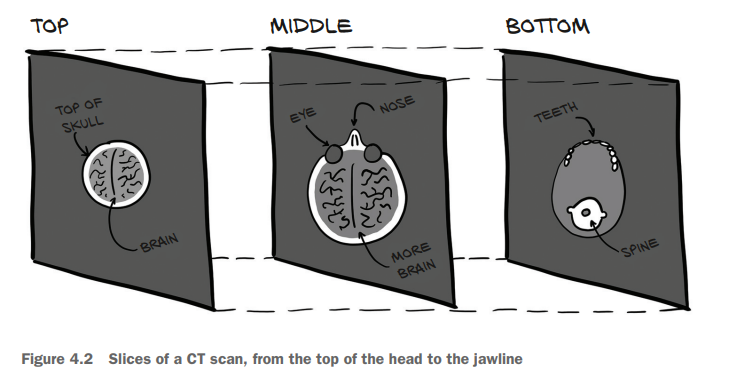
- In some contexts, such as medical imaging with CT (Computed tomography) scans, we deal with sequences of images stacked along the head-to-foot axis, each corresponding to a slice across the human body.
    - In CT Scans, the intensity represents the density of the different parts of the body
    - CTs only have a single intensity channel, similar to grayscale images
        - This means that often, the channel dimension is left out of native data formats
        - Similar to the last example, the raw data only has 3 dimensions
        - By stacking 2D slices into a 3D tensor, we can build a volumetric representation of 3D anatomy
        - Unlike the image data, the extra dimension represents the offset of physical space, rather than a particular band of the visible spectrum
- Part 2 of this book will tackle a medical imaging problem
- For now, an abstract idea of volumetric data can be represented in a 5D tensor **NxCxDxHxW** (Batch_size, channel, density, height, width)

#### Loading a specialized format
- Loading a sample CT scan using ```volread``` in ```imageio```

In [11]:
dir_path = './data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083'
vol_arr = imageio.volread(dir_path, 'DICOM')
print(vol_arr.shape)

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 91/99  (91.999/99  (100.0%)
(99, 512, 512)


PyTorch expects a channels dimension, which we can make using ```unsqueeze```

In [12]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
print(vol.shape) # [Channel, Density, Height, Width]
# We can also add an optional batch dimension

torch.Size([1, 99, 512, 512])


At this point we could build a 5D dataset by stacking multiple volumes along the batch direction

### Representing Tabular Data
- The simplest data in machine learning is sitting in a spreadsheet, CSV, or database as a table
    - One row per sample
    - One column per feature
        - Note that sometimes this relationship is transposed
- At first we will assume there is no meaning to the order of samples by row in the dataset
    - The data is a collection of independent samples
    - We will look at time series data soon
- Tabular data is typically not homogenous (One data type)
    - PyTorch tensors are homogenous so we need to be weary


#### Using a real-world dataset
- Encode heterogeneous, real-world data into a tensor of floating-point numbers
- We will be working with the Wine Quality dataset containing chemical characterizations of portugese wines
- A possible ML task with this data is predicting the quality score of a wine from its chemical characterization


#### Loading a wine data tensor
- 3 Options for loading a CSV file:
    - The ```csv``` module shipped with python
    - NumPy
    - Pandas
        - Pandas is the most time and memory efficient, but it won't be touched on here
        - I also prefer Pandas for loading and examining CSV files

In [13]:
import csv
# Load data
wine_path = './data/p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1) # Cast to 32-bit
print(wineq_numpy)

[[ 7.    0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 8.1   0.28  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.46  9.4   6.  ]
 [ 5.5   0.29  0.3  ...  0.38 12.8   7.  ]
 [ 6.    0.21  0.38 ...  0.32 11.8   6.  ]]


In [14]:
# Checking data
col_list = next(csv.reader(open(wine_path), delimiter=';'))
print(wineq_numpy.shape, col_list)

(4898, 12) ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [15]:
wineq = torch.from_numpy(wineq_numpy) # convert to torch tensor
print(wineq.shape, wineq.dtype)

torch.Size([4898, 12]) torch.float32


#### Aside on Continuous, Ordinal, and Categorical Values
- Continuous Values:
    - Strictly Ordered
    - Differences between various values have a strict meaning
        - Package A is 2 KG heavier than package B
    - If you count or measure something with units, it is probably a continuous value
    - Continuous values are further divided into two categories:
        - *Ratio Scale*: It makes sense to say a continuous value is twice as large as another
            - Things can be twice as far or twice as heavy
        - *Interval Scale*: There is a notion of difference, but not the notion of scale
            - It is not reasonable to say 6:00 PM is twice as late at 3:00 PM but the difference is still encoded as a distance in time



- Ordinal Values:
    - Strictly ordered
    - No relationship other than ordering
    - Example:
        - Ordering a small (1), medium (2), or large drink (3)
        - Large is encoded to come after medium and small, but it isn't explicity scaled accordingly
            - A large (3) is not explicitly 50% larger than a medium (2)
            - We could however readjust them to be fluid ounces: small (8 floz), medium (12 floz), large (24 floz)
                - In this case, we can say they are on the *Ratio Scale*
                    - Note: The book says it would be an interval value but I'm not really sure why, I think it would be on the Ratio scale (maybe I'm misinterpreting)
        - The notion of distance is gone
    - We can't "do math" on the values other than ordering them
    - Trying to average large=3 and small=1 does not result in a medium drink (2)



- Categorical Values:
    - Neither ordering nor numerical meaning
    - Often just enumerations of possibilities assigned to arbitrary numbers
    - Example:
        - Assigning water to 1, coffee to 2, soda to 3, and milk to 4
        - There is no real logic to placing water first and milk last, thy simply need distinct values to differentiate them
        - We could assign cofee to 10 if we wanted and milk to -1
    - Assigning values **0...N-1** will have advantages for one-hot encoding
    - Since the numerical values have no meaning, they are said to be on the *Nominal Scale*

#### Representing Scores (Wine data)
- We can keep score as a continuous variable, keep it as a real number, and perform a regression task
- Or we can treat score as a label and treat it as a classification task
- In both approaches, we remove the score from the tensor of input data to prevent ground truth from entering our model

In [16]:
data = wineq[:, :-1] # All rows and all cols except the last column
print(data, '\n', data.shape)

tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
        [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
        [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
        [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
        [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]) 
 torch.Size([4898, 11])


In [17]:
target = wineq[:, -1] # All rows and only the last column
print(target, target.dtype)
print(target.shape)

tensor([6., 6., 6.,  ..., 6., 7., 6.]) torch.float32
torch.Size([4898])


We have two options for transforming the ```target``` tensor into a tensor of labels
- We can simply treat labels as a integer vector of scores
    - If targets were string labels, like *wine color*, assigning an integer number to each string would let us follow the same approach
- Or we can build a *one-hot encoding* of the scores
    - Encode each of the 10 scores to a vector with 10 elements, with all elements set to 0 but one, at a different index for each possible score
    - This way, a score of 1 could be mapped to the vector (1, 0, 0, 0, 0, 0, 0, 0, 0, 0), and a score of 5 could be mapped to (0, 0, 0, 0, 1, 0, 0, 0, 0, 0), and so on
        - The fact that score is mapped to the exact index in the encoding is coincidence in this case, we could shuffle their assignment and it would not change the model

In [18]:
# Treating score as a integer vector
target = wineq[:, -1].long()
print(target, target.dtype)

tensor([6, 6, 6,  ..., 6, 7, 6]) torch.int64


#### One-hot encoding
- Pros and Cons of Integer Encoding for wine dataset:
    - Keeping wine quality scores as an integer vector of scores induces an ordering on the scores
        - this may be appropriate for this case, since a score of 1 is lower than a score of 4
    - It also induces a sort of distance on the scores (distance between 1 and 3 is the same as 2 and 4
        - This may not be the case but if it is, great
- One-hot encoding:
    - For discrete score values (like grape variety), one hot encoding is often more appropriate
        - No implied ordering or distance
    - One-hot encoding is also appropriate for quantitative scores when fractional values in between integer scores make no sense. 
        - For when the score is either *this* or *that*

We can create a one-hot encoded tensor by calling ```scatter_``` from a source tensor
- this occurs in place, denoted by the trailing underscore
- Arguments:
    - dim: The dimension along which the following two arguments are specied
    - index: The column tensor indicating the indices of the elements to scatter
        - This is required to have the same dimensions as the method calling tensor
        - We add a dummy dimension to ```target``` using its method ```unsqueeze```
    - src: a tensor containing the elements to scatter or a single scalar to scatter
        - 1.0 in this case



https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html#torch.Tensor.scatter_

In [22]:
# One-hot tensor
print(target, target.shape)
target_onehot = torch.zeros(target.shape[0], 10) # (vector_length, num_classes)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0) # (dim, index, src)

tensor([6, 6, 6,  ..., 6, 7, 6]) torch.Size([4898])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

#### When to categorize
- What to do for ordinal data?
    - No general recipe; most commonly, such data is either treated as categorical (losing the order part; hoping to pick it back up in training if there are only a few categories) or continuous (introducing an arbitrary notion of distance)
    - 
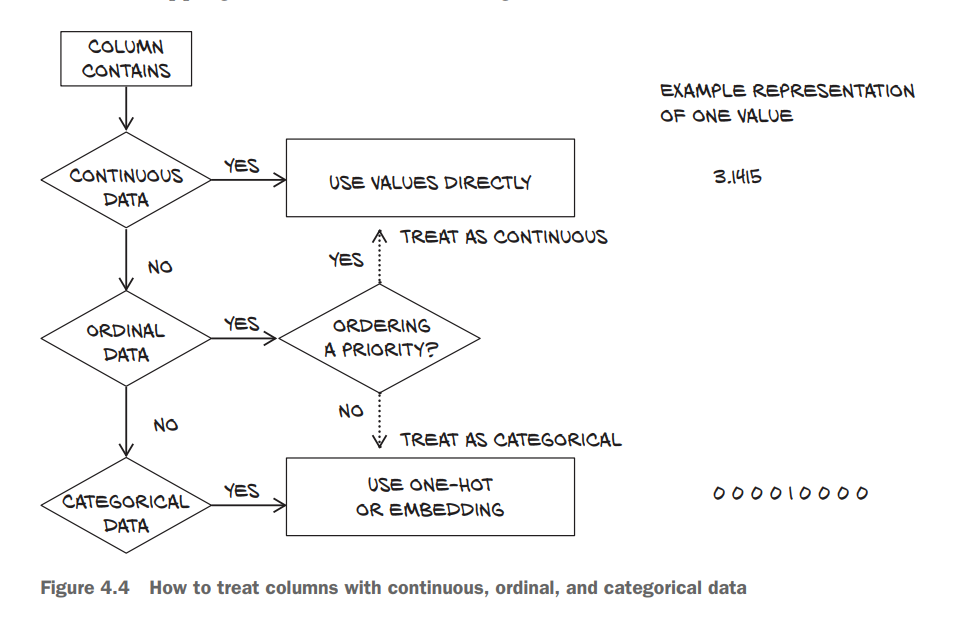


Back to wine data:

In [29]:
# Compute mean and standard deviation of each column
data_mean = torch.mean(data, dim=0) # dim=0; rows are the samples to avg across
print(f'Mean Values: {data_mean}\n')
data_var = torch.var(data, dim=0)
print(f'Column Variations: {data_var}')

Mean Values: tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

Column Variations: tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])


In [32]:
# Now we can normalize the data across the entire dataset
data_normalized = (data - data_mean) / torch.sqrt(data_var) # subtract mean and divide by sqrt(var)
print(data_normalized) # Should have mean~=0 and std~=1

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])


#### Finding thresholds

In [34]:
# Checking poor quality samples
bad_indexes = target <= 3
print(bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum())
print(bad_indexes)

torch.Size([4898]) torch.bool tensor(20)
tensor([False, False, False,  ..., False, False, False])


In [39]:
bad_data = data[bad_indexes]
print(bad_data[:10], bad_data.shape) # First 10 samples of bad data

tensor([[8.5000e+00, 2.6000e-01, 2.1000e-01, 1.6200e+01, 7.4000e-02, 4.1000e+01,
         1.9700e+02, 9.9800e-01, 3.0200e+00, 5.0000e-01, 9.8000e+00],
        [5.8000e+00, 2.4000e-01, 4.4000e-01, 3.5000e+00, 2.9000e-02, 5.0000e+00,
         1.0900e+02, 9.9130e-01, 3.5300e+00, 4.3000e-01, 1.1700e+01],
        [9.1000e+00, 5.9000e-01, 3.8000e-01, 1.6000e+00, 6.6000e-02, 3.4000e+01,
         1.8200e+02, 9.9680e-01, 3.2300e+00, 3.8000e-01, 8.5000e+00],
        [7.1000e+00, 3.2000e-01, 3.2000e-01, 1.1000e+01, 3.8000e-02, 1.6000e+01,
         6.6000e+01, 9.9370e-01, 3.2400e+00, 4.0000e-01, 1.1500e+01],
        [6.9000e+00, 3.9000e-01, 4.0000e-01, 4.6000e+00, 2.2000e-02, 5.0000e+00,
         1.9000e+01, 9.9150e-01, 3.3100e+00, 3.7000e-01, 1.2600e+01],
        [1.0300e+01, 1.7000e-01, 4.7000e-01, 1.4000e+00, 3.7000e-02, 5.0000e+00,
         3.3000e+01, 9.9390e-01, 2.8900e+00, 2.8000e-01, 9.6000e+00],
        [7.9000e+00, 6.4000e-01, 4.6000e-01, 1.0600e+01, 2.4400e-01, 3.3000e+01,
         2.27

In [42]:
bad_data = data[bad_indexes]
mid_data = data[((target > 3) & (target < 7))]
good_data = data[target >= 7]

In [44]:
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

print(f'Bad Mean: {bad_mean}\n')
print(f'Mid Mean: {mid_mean}\n')
print(f'Good Mean: {good_mean}')

Bad Mean: tensor([7.6000e+00, 3.3325e-01, 3.3600e-01, 6.3925e+00, 5.4300e-02, 5.3325e+01,
        1.7060e+02, 9.9488e-01, 3.1875e+00, 4.7450e-01, 1.0345e+01])

Mid Mean: tensor([6.8869e+00, 2.8153e-01, 3.3644e-01, 6.7051e+00, 4.7841e-02, 3.5424e+01,
        1.4183e+02, 9.9447e-01, 3.1808e+00, 4.8707e-01, 1.0265e+01])

Good Mean: tensor([6.7251e+00, 2.6535e-01, 3.2606e-01, 5.2615e+00, 3.8160e-02, 3.4550e+01,
        1.2525e+02, 9.9241e-01, 3.2151e+00, 5.0014e-01, 1.1416e+01])


In [45]:
# Make it look better
for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print('{:2} {:20} {:6.2f} {:6.2f} {:6.3f}'.format(i, *args))

 0 fixed acidity          7.60   6.89  6.725
 1 volatile acidity       0.33   0.28  0.265
 2 citric acid            0.34   0.34  0.326
 3 residual sugar         6.39   6.71  5.262
 4 chlorides              0.05   0.05  0.038
 5 free sulfur dioxide   53.33  35.42 34.550
 6 total sulfur dioxide 170.60 141.83 125.245
 7 density                0.99   0.99  0.992
 8 pH                     3.19   3.18  3.215
 9 sulphates              0.47   0.49  0.500
10 alcohol               10.34  10.26 11.416


In [49]:
# Checking sulfur dioxide threshold
total_sulfur_threshold = 141.83
total_sulfur_data = data[:, 6] # All rows, only column 6
predicted_indexes = torch.lt(total_sulfur_data, total_sulfur_threshold) # Larger than -> .lt(x < y)

print(predicted_indexes, predicted_indexes.shape)
print(f'Total True: {predicted_indexes.sum()}')

tensor([False,  True,  True,  ...,  True,  True,  True]) torch.Size([4898])
Total True: 2727


This threshold predicts almost half of the wines will be of high quality
- Lets compare that with the ground truth:

In [58]:
actual_indexes = target > 5
print(actual_indexes, actual_indexes.shape)
print(f'Total True: {actual_indexes.sum()}')

tensor([True, True, True,  ..., True, True, True]) torch.Size([4898])
Total True: 3258


Looks like the ratio is close, but how true are our predictions?

In [59]:
n_matches = torch.sum(actual_indexes & predicted_indexes).item()
n_predicted = torch.sum(predicted_indexes).item()
n_actual = torch.sum(actual_indexes).item()

print(f'n_matches: {n_matches}')
print(f'False Positive %: {1.0 - (n_matches / n_predicted):.3f}')
print(f'Accuracy: {n_matches / n_actual:.3f}')

n_matches: 2018
False Positive %: 0.260
Accuracy: 0.619


Looks like we can get about 60% accuracy splitting on just this variable alone
- Clearly sulfur dioxide content is a key factor in wine quality
- Its naive to split the model on just one variable, which explains the sub par performs
    - It is however better than random chance


We will introduce more proper model performance metrics later

###  Working with time series
- Previously, we worked with tabular data where each sample was independent from the others.
    - Order did not matter
    - There was also no row encoding information about what rows came earlier or later
- Swapping to a new dataset: Washington DC bike-sharing service reporting the hourly counts of rental bikes in 2011-2012
    - As well as weather, and seasonal information
- The goal is to take a flat, 2D dataset and transform it into a 3D one

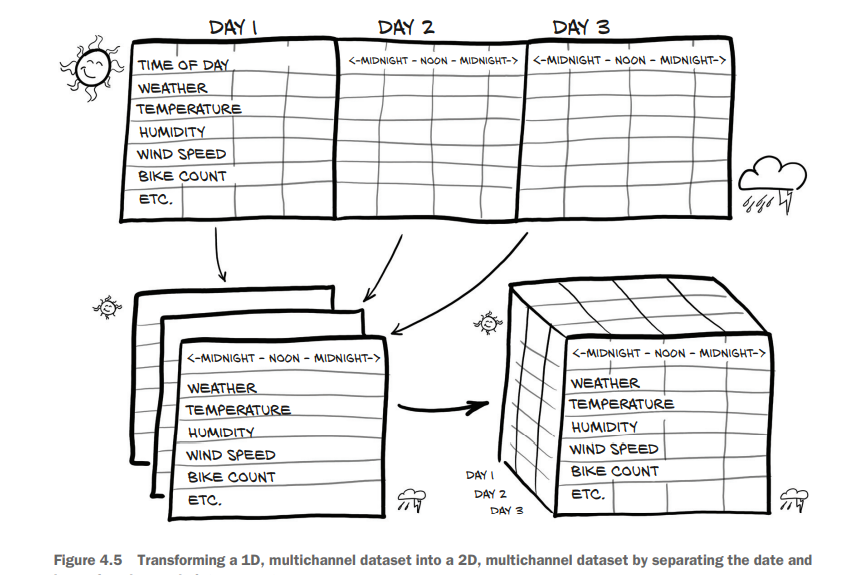

#### Adding a time dimension
- In the source data, each row is a separate hour of data
- We want to change the row-per-hour organization schema so that we have one axis that increases at a rate of one day per index increment, and another that represents the hour of the day. We also add a third axis to represent our column data
- For every hour, the dataset reports the following:
    - Index of record: ```instant```
    - Day of month: ```day```
    - Season: ```season``` (1:spring, 2:summer, 3:fall, 4:winter)
    - Year: ```yr``` (0:2011, 1:2012)
    - Month: ```mnth``` (1 to 12)
    - Hour: ```hr``` (0 to 23)
    - Holiday status: ```holiday```
    - Day of week: ```weekday```
    - Working day status: ```working```
    - Weather situations: ```weathersit``` (1:clear, 2:mist, 3: light rain/snow, 4:heavy rain/snow)
    - Temperature in C°: ```temp```
    - Perceived Temperature in C°: ```atemp```
    - Humidity: ```hum```
    - Wind speed: ```windspeed```
    - Number of casual users: ```casual```
    - Number of registered users: ```registered```
    - Count of rental bikes: ```cnt```

In [62]:
bikes_numpy = np.loadtxt("./data/p1ch4/bike-sharing-dataset/hour-fixed.csv",
                        dtype=np.float32, delimiter=',', skiprows=1,
                        converters={1: lambda x: float(x[8:10])})
# Converts date strings to numbers corresponding to day of month ^^^
bikes = torch.from_numpy(bikes_numpy)
print(bikes)

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])


In a time series dataset:
    - Rows represent individual